# Cervix Segmentation Final Capstone

Cervical cancer is easily preventable when it is discovered before its precancerous stages. The biggest hurdle when prescribing treatement is determining the type of cervix. 

This capstone sets out to use Image Segmentation and various Convolutional Neural Network architectures to accurately predict cervix types based on medical images. 

In this particular dataset, there are 2615 images of cervixes categorized by type. There are 3 types of cervixes. The differences are outlined in the image below.

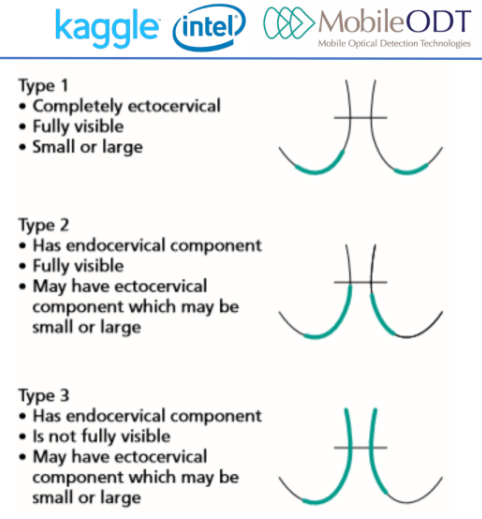

In [5]:
from IPython.display import Image
Image(filename='3_cervix_types.png', width=362, height=444) 

In [1]:
# graphical plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from collections import Counter
from sklearn import mixture
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import measure

In [2]:
# system folder access
from glob import glob
import os
from multiprocessing import Pool, cpu_count
from functools import partial
from subprocess import check_output

In [3]:
# rid myself of matplotlib font issue
import warnings
warnings.filterwarnings("ignore")

In [4]:
# neural network modeling tools
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Flatten, BatchNormalization,
                         Input, AveragePooling2D, merge, Activation,
                         Concatenate)
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# ensures image ordering adheres to tensorflow
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


## Retrieving Data

In [5]:
# check folder architecture
print(check_output(["ls", "../train"]).decode("utf-8"))

Type_1
Type_2
Type_3



In [6]:
# set image access folder to variable
TRAIN_DATA = "../train"

In [7]:
types = ['Type_1', 'Type_2', 'Type_3']

In [8]:
%%time
# creates list from image ids found in filenames in each type folder 
type_ids = []
type_files = []

for type in enumerate(types):
    type_i_files = glob(os.path.join(TRAIN_DATA, type[1], "*.jpg"))
    type_files.append(type_i_files)
    type_i_ids = np.array([s[len(TRAIN_DATA)+8:-4] for s in type_i_files])
    type_ids.append(type_i_ids)

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 16.6 ms


         Type 1                  Type 2                    Type 3


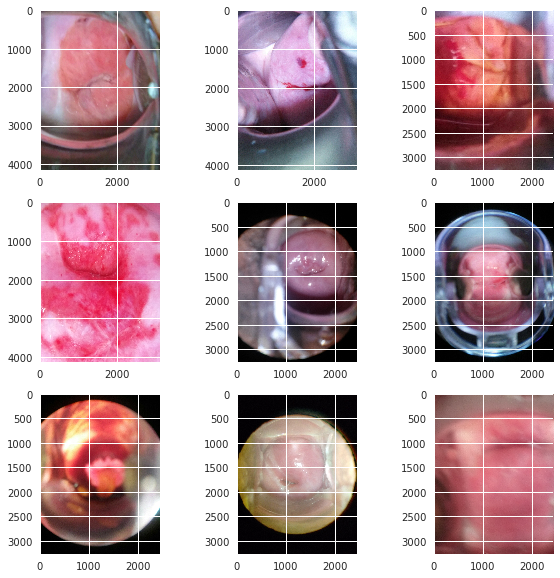

In [15]:
# sample images from the dataset, separated by column
plt.figure(figsize=(10, 10))

print('         Type 1                  Type 2                    Type 3')
plot_number = 1
for i in range(3):
    for j in range(3):
        img = type_files[j][i]
        #print(img)
        ax = plt.subplot(3, 3, plot_number)
        plt.imshow(plt.imread(img))   
        plot_number = plot_number + 1

In [9]:
def get_filename(image_id, image_type):
    """
    Method to grab image file path from its id and tpye
    """
    if image_type == "Type_1" or \
        image_type == "Type_2" or \
        image_type == "Type_3":
        data_path = os.path.join(TRAIN_DATA, image_type)
    else:
        raise Exception("Image type {} is not recognized".format(image_type))
        
    ext = 'jpg'
    return os.path.join(data_path, "{}.{}".format(image_id, ext))

In [10]:
def get_image_data(image_id, image_type):
    """
    Method to get image data as np.array that specifies image id and type
    """
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image: {}, {}".format(image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
# Crop images that may have circular frames present
# Find the largest inscribed rectangled in the thresholded image
# image is cropped to that rectangle

def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else: 
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i-position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()    
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea

In [12]:
def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3]+1-maxArea[0]/abs(maxArea[1]-maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

In [13]:
def cropCircle(img):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)
            
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
            
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)
    
    rect = maxRect(ff)
    rectangle = [min(rect[0],rect[2]), max(rect[0],rect[2]), min(rect[1],rect[3]), max(rect[1],rect[3])]
    img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)
    
    return [img_crop, rectangle, tile_size]

In [14]:
# For initial delineation of cervix, use two features
    # a color: the higher the a value, the redder the pixel color
    # R: distance of a pixel from image center -> spatial information
    #    -> support extraction of continuous regions

def Ra_space(img, Ra_ratio, a_threshold):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = np.zeros((w*h, 2))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w/2-i)*(w/2-i) + (h/2-j)*(h/2-j))
            Ra[i*h+j, 0] = R
            Ra[i*h+j, 1] = min(imgLab[i][j][1], a_threshold)
            
    Ra[:,0] /= max(Ra[:,0])
    Ra[:,0] *= Ra_ratio
    Ra[:,1] /= max(Ra[:,1])

    return Ra

In [15]:
# image is separated into two clusters in the 2-D (a-R) features space
# use of Gaussian mixture modeling
# initialized by k-means procedure

def get_and_crop_image(image_id, image_type):
    img = get_image_data(image_id, image_type)
    initial_shape = img.shape
    [img, rectangle_cropCircle, tile_size] = cropCircle(img)
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = Ra_space(imgLab, 1.0, 150)
    a_channel = np.reshape(Ra[:,1], (w,h))
    
    g = mixture.GaussianMixture(n_components = 2, covariance_type = 'diag', random_state = 0, init_params = 'kmeans')
    image_array_sample = shuffle(Ra, random_state=0)[:1000]
    g.fit(image_array_sample)
    labels = g.predict(Ra)
    labels += 1 # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.
    
    # The cluster that has the highest a-mean is selected.
    labels_2D = np.reshape(labels, (w,h))
    gg_labels_regions = measure.regionprops(labels_2D, intensity_image = a_channel)
    gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
    cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

    mask = np.zeros((w * h,1),'uint8')
    mask[labels==cervix_cluster] = 255
    mask_2D = np.reshape(mask, (w,h))

    cc_labels = measure.label(mask_2D, background=0)
    regions = measure.regionprops(cc_labels)
    areas = [prop.area for prop in regions]

    regions_label = [prop.label for prop in regions]
    largestCC_label = regions_label[areas.index(max(areas))]
    mask_largestCC = np.zeros((w,h),'uint8')
    mask_largestCC[cc_labels==largestCC_label] = 255

    img_masked = img.copy()
    img_masked[mask_largestCC==0] = (0,0,0)
    img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY);
            
    _,thresh_mask = cv2.threshold(img_masked_gray,0,255,0)
            
    kernel = np.ones((11,11), np.uint8)
    thresh_mask = cv2.dilate(thresh_mask, kernel, iterations = 1)
    thresh_mask = cv2.erode(thresh_mask, kernel, iterations = 2)
    _, contours_mask, _ = cv2.findContours(thresh_mask.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours_mask, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(img, main_contour, -1, 255, 3)
    
    x,y,w,h = cv2.boundingRect(main_contour)
    
    rectangle = [x+rectangle_cropCircle[2],
                 y+rectangle_cropCircle[0],
                 w,
                 h,
                 initial_shape[0],
                 initial_shape[1],
                 tile_size[0],
                 tile_size[1]]

    return [image_id, img, rectangle]

In [16]:
def parallelize_image_cropping(image_ids):
    """
    Create csv file containing the relevant resizing information for each image.
    Use multiple process to increase speed.
    """
    out = open('rectangles.csv', "w")
    out.write("image_id,type,x,y,w,h,img_shp_0_init,img_shape1_init,img_shp_0,img_shp_1\n")
    imf_d = {}
    p = Pool(cpu_count())
    for type in enumerate(types):
        print(type)
        partial_get_and_crop = partial(get_and_crop_image, image_type = type[1])    
        ret = p.map(partial_get_and_crop, image_ids[type[0]])
        
        for i in range(len(ret)):
            out.write(image_ids[type[0]][i])
            out.write(',' + str(type[1]))
            out.write(',' + str(ret[i][2][0]))
            out.write(',' + str(ret[i][2][1]))
            out.write(',' + str(ret[i][2][2]))
            out.write(',' + str(ret[i][2][3]))
            out.write(',' + str(ret[i][2][4]))
            out.write(',' + str(ret[i][2][5]))
            out.write(',' + str(ret[i][2][6]))
            out.write(',' + str(ret[i][2][7]))
            out.write('\n')
            img = get_image_data(image_ids[type[0]][i], type[1])
            if(img.shape[0] > img.shape[1]):
                tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
            else:
                tile_size = (256, int(img.shape[0]*256/img.shape[1]))
            img = cv2.resize(img, dsize=tile_size)
            cv2.rectangle(img,
                          (ret[i][2][0], ret[i][2][1]), 
                          (ret[i][2][0]+ret[i][2][2], ret[i][2][1]+ret[i][2][3]),
                          255,
                          2)
            if i % 270 == 0:
                plt.imshow(img)
                plt.show()
        ret = []
    out.close()

    return

Below are images that contain examples of the potential crops for images passing through the image cropping function.

(0, 'Type_1')


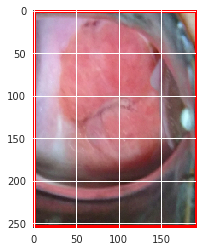

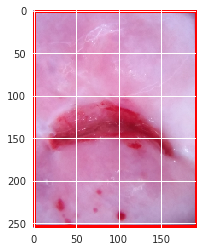

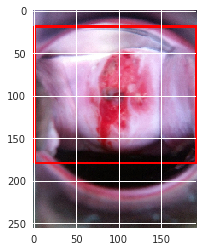

(1, 'Type_2')


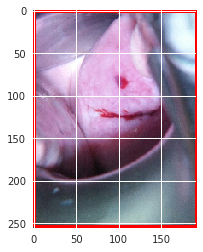

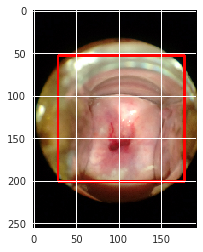

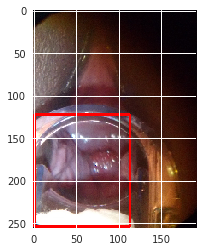

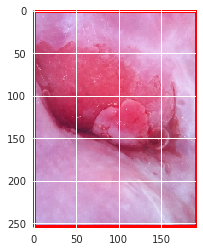

(2, 'Type_3')


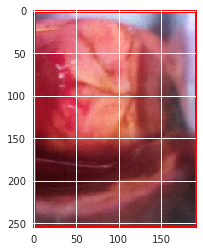

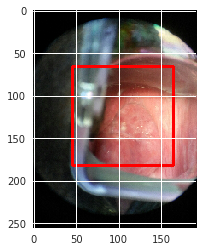

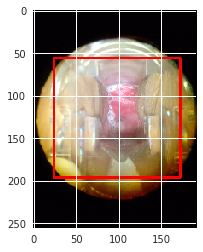

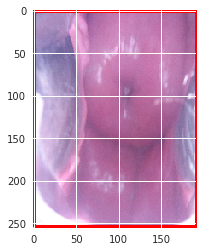

CPU times: user 37min 31s, sys: 1min 32s, total: 39min 3s
Wall time: 25min 43s


In [17]:
%%time
parallelize_image_cropping(type_ids)

As you can see, some images require large crops to keep the pertinent information, while others did not fulfill the requirements necessary for truncation.

## Resize Images

In [17]:
# import resizing dimensions from newly created csv
df = pd.read_csv('rectangles.csv')

In [18]:
df.head(5)

,image_id,type,x,y,w,h,img_shp_0_init,img_shape1_init,img_shp_0,img_shp_1
0,864,Type_1,1,1,190,253,4160,3120,192,256
1,2234,Type_1,1,1,190,253,4128,3096,192,256
2,2112,Type_1,1,39,176,176,3264,2448,192,256
3,1704,Type_1,1,32,166,178,4160,3120,192,256
4,1346,Type_1,17,58,156,151,4160,3120,192,256


The rectangles.csv file has information containing the crop dimensions (x, y, w, h), the type of cervix, its image id (pulled from the filepath), its initial dimensions, and the dimensions used to make the crop.

In [19]:
# all files are accounted for
df.shape

(2615, 10)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 10 columns):
image_id           2615 non-null int64
type               2615 non-null object
x                  2615 non-null int64
y                  2615 non-null int64
w                  2615 non-null int64
h                  2615 non-null int64
img_shp_0_init     2615 non-null int64
img_shape1_init    2615 non-null int64
img_shp_0          2615 non-null int64
img_shp_1          2615 non-null int64
dtypes: int64(9), object(1)
memory usage: 204.4+ KB


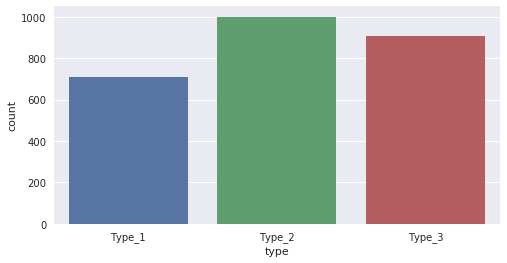

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(df['type'])

In [22]:
# concatenate all image paths into a single list
all_files = []

for type in enumerate(types):
    all_files.append(glob(os.path.join(TRAIN_DATA, type[1], "*.jpg")))

all_files = np.concatenate(all_files)

In [23]:
len(all_files)

2615

In [24]:
# create a dictionary: key -> image path, value -> resizing dimensions

item_dict = {}
for item in all_files:
    item_idx = int(item.split('/')[-1][:-4])
    type_idx = item.split('/')[2]
    
    # use both id and type as keys to ensure uniqueness
    match = df[(df['image_id'] == item_idx) & (df['type'] == type_idx)]

    # pulls singular item from dictionary
    xd = int(match['x'].item())
    yd = int(match['y'].item())
    wd = int(match['w'].item())
    hd = int(match['h'].item())
    img_shp_0d = int(match['img_shp_0'].item())
    img_shp_1d = int(match['img_shp_1'].item())
    type_d = match['type'].item()
    
    item_dict[item_idx, type_d] = (xd, yd, wd, hd, img_shp_0d, img_shp_1d, type_d) 
    # xd:0, yd:1, wd:2, hd:3, img_0d:4, img_1d:5

In [25]:
len(item_dict.items())

2615

In [27]:
%%time

# empty lists for x, y values
labels = []
segmented_images = []

for i, item in enumerate(all_files):
    # grab image id and type from filename, used to access dictionary
    item_ind = int(item.split('/')[-1][:-4])
    type_ind = item.split('/')[2]
    
    # read in image pixels
    img = cv2.imread(item)
    
    # return resizing information from dict
    x_i, y_i, w_i, h_i, img_shp_0_i, img_shp_1_i, type_i = item_dict[item_ind, type_ind]
    
    labels.append(type_i)
    
    # resize to new image dimensions
    resized = cv2.resize(img, (img_shp_0_i, img_shp_1_i))

    # crop image to segmented area
    crop_img = resized[y_i:y_i+h_i, x_i:x_i+w_i]
    
    # resize image to an even smaller value for faster processing
    desired_size = 64
    old_size = crop_img.shape[:2]
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    im = cv2.resize(crop_img, (new_size[1], new_size[0]))
    
    # use copyMakeBorder to maintain aspect ratio, while maintaing uniform image size
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    
    segmented_images.append(new_im)

CPU times: user 9min 14s, sys: 26.9 s, total: 9min 41s
Wall time: 9min 54s


In [28]:
len(segmented_images), len(labels)

(2615, 2615)

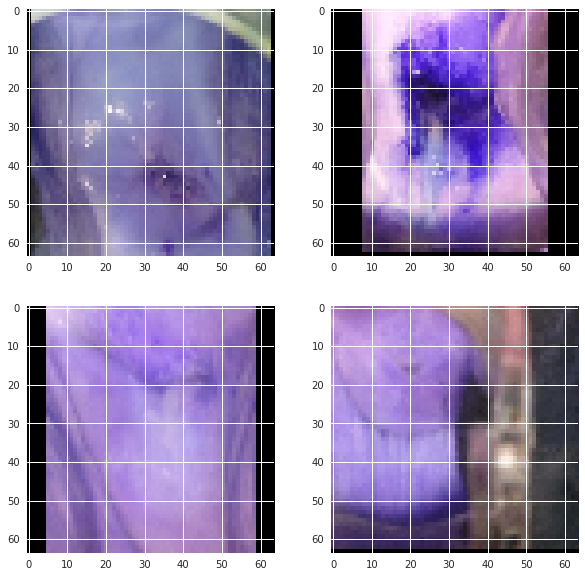

In [28]:
from keras.preprocessing.image import array_to_img
from random import randrange

plt.figure(figsize=(10, 10))

plot_number = 1

for i in range(4):
    rand = randrange(0, len(segmented_images))
    img = array_to_img(segmented_images[rand])
    ax = plt.subplot(2, 2, plot_number)
    plt.imshow(img)
    plot_number = plot_number + 1

Above are samples that indicate what the newly added borders look like. The use of matplotlib's imshow alters the coloring in a way that cv2 does not. This seems to merely be a byproduct of matplotlib usage and does not reflect the actual pixels.

Images are resized to 64 x 64 with black borders to maintain aspect ratio.

In [29]:
Counter(labels)

Counter({'Type_1': 710, 'Type_2': 1000, 'Type_3': 905})

## Data Pre-Processing

In [29]:
import multiprocessing
import collections
import sys
import signal

In [30]:
# Convert string labels to numbers
le = preprocessing.LabelEncoder()
le.fit(labels)
print(le.classes_)
labels = le.transform(labels)
Counter(labels)

['Type_1' 'Type_2' 'Type_3']


Counter({0: 710, 1: 1000, 2: 905})

In [31]:
# split data -> stratified by label -> images as X, labels as y
X_train, X_test, y_train, y_test = train_test_split(segmented_images, 
                                                    labels, 
                                                    test_size=0.15, 
                                                    random_state=42,
                                                    stratify=labels)

In [32]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [33]:
# reshape with size of input values for network input
X_train = X_train.reshape(X_train.shape[0], 64, 64, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3).astype('float32')

In [34]:
# divide by 255 to ensure image pixel values are between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [35]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train, num_classes=3)
y_test = np_utils.to_categorical(y_test, num_classes=3)
num_classes = y_test.shape[1]

In [36]:
X_test.shape, X_train.shape

((393, 64, 64, 3), (2222, 64, 64, 3))

In [37]:
y_test.shape, y_train.shape

((393, 3), (2222, 3))

In [38]:
# built-in keras image preprocessing
# datagen = ImageDataGenerator(rotation_range=30,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              zoom_range=0.2,
#                              fill_mode='nearest')

In [39]:
def plot_model(model_history, model_name):
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history.history['acc'])
    ax1.plot(model_history.history['val_acc'])
    ax1.set_title(model_name + ' Model Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')

    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title(model_name + ' Model Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

## Build Basic CNN

Firstly, I created a very basic CNN model to familiarize myself with the Keras module and its inner machinations. The models make use of Model Checkpointing, saving the best performing model for later ensemble usage.

In [51]:
import tensorflow as tf
tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32))

In [53]:
def basic_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3),
                     data_format="channels_last"))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

filepath = 'basiccnn.best.weight.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list = [checkpoint]

model = basic_cnn_model()

basic_cnn_history = model.fit(X_train, y_train, batch_size=10, 
                                       validation_data=(X_test, y_test),
                                       epochs=50, 
                                       callbacks=callbacks_list, 
                                       verbose=1)

Train on 2222 samples, validate on 393 samples
Epoch 1/50
2222/2222 [==============================] - 28s - loss: 1.1375 - acc: 0.3771 - val_loss: 1.0852 - val_acc: 0.3893
Epoch 2/50
2222/2222 [==============================] - 27s - loss: 1.0777 - acc: 0.3956 - val_loss: 1.0853 - val_acc: 0.3715
Epoch 3/50
2222/2222 [==============================] - 27s - loss: 1.0738 - acc: 0.3947 - val_loss: 1.1058 - val_acc: 0.3613
Epoch 4/50
2222/2222 [==============================] - 27s - loss: 1.0700 - acc: 0.4185 - val_loss: 1.0935 - val_acc: 0.3817
Epoch 5/50
2222/2222 [==============================] - 27s - loss: 1.0587 - acc: 0.4100 - val_loss: 1.1057 - val_acc: 0.3766
Epoch 6/50
2222/2222 [==============================] - 27s - loss: 1.0506 - acc: 0.4131 - val_loss: 1.1141 - val_acc: 0.3995
Epoch 7/50
2222/2222 [==============================] - 27s - loss: 1.0522 - acc: 0.4262 - val_loss: 1.1047 - val_acc: 0.3664
Epoch 8/50
2222/2222 [==============================] - 27s - loss: 1.0

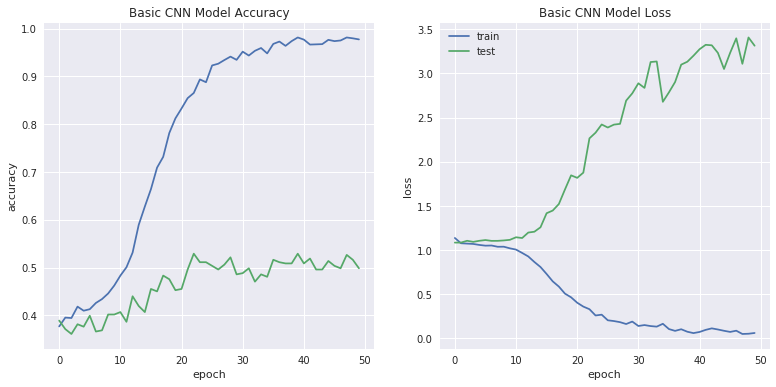

In [124]:
plot_model(basic_cnn_history, 'Basic CNN')

The Basic CNN does not generalize very well. The first epoch provides the best performing model and the loss balloons upwards from there. However, the accuracy metric has a general uptick as the model processes.

- Best Loss: 1.08521

## Alex-Net

I then fit an AlexNet model. This is a model created in 2012 that served as the first coming out party for CNNs in the computer vision community. It's certaintly more complicated than the basic model, containg 5 convolutional layers and 3 fully connected layers.

In [55]:
def alexnet_model():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(3,3),
                     strides=(2,2),
                     activation='relu',
                     padding='same',
                     input_shape=(64,64,3),
                     data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=(2,2),
                           strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

    
filepath = 'alexnet.best.weight.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list = [checkpoint]

model = alexnet_model()

alexnet_history = model.fit(X_train, y_train, batch_size=10, 
                                       validation_data=(X_test, y_test),
                                       epochs=50, 
                                       callbacks=callbacks_list, 
                                       verbose=1)

Train on 2222 samples, validate on 393 samples
Epoch 1/50
2222/2222 [==============================] - 55s - loss: 7.2248 - acc: 0.3632 - val_loss: 2.0436 - val_acc: 0.3817
Epoch 2/50
2222/2222 [==============================] - 56s - loss: 2.1345 - acc: 0.3483 - val_loss: 1.4835 - val_acc: 0.2774
Epoch 3/50
2222/2222 [==============================] - 56s - loss: 2.0836 - acc: 0.3501 - val_loss: 1.3873 - val_acc: 0.3333
Epoch 4/50
2222/2222 [==============================] - 53s - loss: 2.0221 - acc: 0.3555 - val_loss: 1.9092 - val_acc: 0.3588
Epoch 5/50
2222/2222 [==============================] - 53s - loss: 1.9525 - acc: 0.3695 - val_loss: 2.1621 - val_acc: 0.3461
Epoch 6/50
2222/2222 [==============================] - 55s - loss: 2.0129 - acc: 0.3434 - val_loss: 1.0969 - val_acc: 0.3410
Epoch 7/50
2222/2222 [==============================] - 54s - loss: 2.0833 - acc: 0.3353 - val_loss: 3.3781 - val_acc: 0.3461
Epoch 8/50
2222/2222 [==============================] - 54s - loss: 1.9

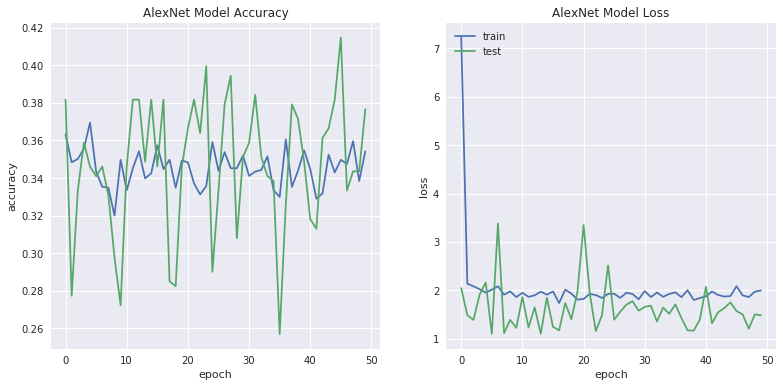

In [125]:
plot_model(alexnet_history, 'AlexNet')

The AlexNet did not perform as well as the Basic model according to the metrics. AlexNet accuracy was much more volatile and the loss was consistently lower but its best performing model was not good enough the usurp the Base Model.

- Best Loss: 1.09687

## VGG-16 Net

I then upped the complexity of the model with the VGG-16 net. This model was created in 2014 and uses 16 layers. Makes strict use of 3x3 filters with stride and pad of 1, along with 2x2 maxpooling layers with stride 2. Deep, simple network.

In [58]:
def vgg_model():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(64, 64, 3), data_format='channels_last'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D(padding=(1,1), data_format='channels_last'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    return model

    
    
filepath = 'vgg.best.weight.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')    
    
callback_list = [checkpoint]

model = vgg_model()

vgg_history = model.fit(X_train, y_train, batch_size=10, 
                                       validation_data=(X_test, y_test),
                                       epochs=50, 
                                       callbacks=callback_list, 
                                       verbose=1)

Train on 2222 samples, validate on 393 samples
Epoch 1/50
2222/2222 [==============================] - 154s - loss: 1.1262 - val_loss: 1.0921
Epoch 2/50
2222/2222 [==============================] - 151s - loss: 1.1027 - val_loss: 1.0924
Epoch 3/50
2222/2222 [==============================] - 151s - loss: 1.1033 - val_loss: 1.1391
Epoch 4/50
2222/2222 [==============================] - 151s - loss: 1.1054 - val_loss: 1.1013
Epoch 5/50
2222/2222 [==============================] - 150s - loss: 1.1011 - val_loss: 1.0936
Epoch 6/50
2222/2222 [==============================] - 151s - loss: 1.1029 - val_loss: 1.1025
Epoch 7/50
2222/2222 [==============================] - 150s - loss: 1.1065 - val_loss: 1.0965
Epoch 8/50
2222/2222 [==============================] - 150s - loss: 1.1008 - val_loss: 1.1289
Epoch 9/50
2222/2222 [==============================] - 151s - loss: 1.1011 - val_loss: 1.0909
Epoch 10/50
2222/2222 [==============================] - 152s - loss: 1.1040 - val_loss: 1.0903
Ep

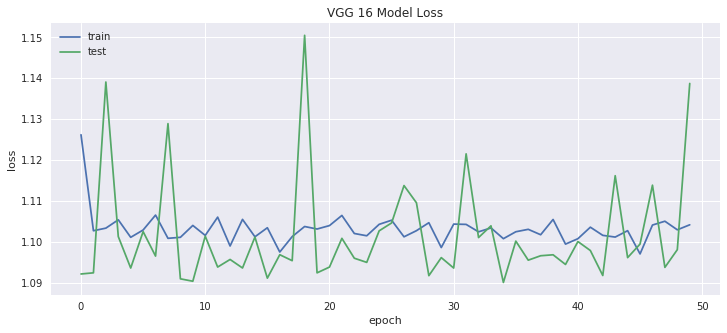

In [122]:
plt.figure(figsize=(12,5))
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG 16 Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

The VGG-16 Net is much less volatile but its loss is only marginally better than the previous models.

- Best Loss: 1.09002

## DenseNet

The DenseNet is slightly different because it does not make use of the sequential keras model. A series of functions are used to generate the necessary model. They are also quite unique because each layer is connected, leading to feature reuse, the need for fewer parameters and maximum information flow between all layers.

In [59]:
batch_size = 11
num_classes = 3
epochs = 3
l = 10
num_filter = 20

In [60]:
# Dense Block
def add_denseblock(input):
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(num_filter, (3,3), 
                            use_bias=False ,padding='same')(relu)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

In [61]:
def add_transition(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(num_filter, (1,1), 
                               use_bias=False ,padding='same')(relu)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [62]:
def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [63]:
input = Input(shape=(64, 64, 3,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D)
First_Transition = add_transition(First_Block)

Second_Block = add_denseblock(First_Transition)
Second_Transition = add_transition(Second_Block)

Third_Block = add_denseblock(Second_Transition)
Third_Transition = add_transition(Third_Block)

Last_Block = add_denseblock(Third_Transition)
output = output_layer(Last_Block)

In [64]:
dense_model = Model(inputs=[input], outputs=[output])

In [68]:
dense_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

filepath = "densenet-best-weight.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2,
                            save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [70]:
dense_history = dense_model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=30,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(X_test, y_test))

Train on 2222 samples, validate on 393 samples
Epoch 1/30
2222/2222 [==============================] - 339s - loss: 1.2571 - acc: 0.3798 - val_loss: 2.0062 - val_acc: 0.3919
Epoch 2/30
2222/2222 [==============================] - 325s - loss: 1.1329 - acc: 0.4257 - val_loss: 1.1120 - val_acc: 0.4173
Epoch 3/30
2222/2222 [==============================] - 324s - loss: 1.1225 - acc: 0.4118 - val_loss: 1.1382 - val_acc: 0.4275
Epoch 4/30
2222/2222 [==============================] - 323s - loss: 1.0769 - acc: 0.4410 - val_loss: 1.2519 - val_acc: 0.3690
Epoch 5/30
2222/2222 [==============================] - 322s - loss: 1.0666 - acc: 0.4554 - val_loss: 1.8263 - val_acc: 0.4046
Epoch 6/30
2222/2222 [==============================] - 324s - loss: 1.0454 - acc: 0.4613 - val_loss: 1.0691 - val_acc: 0.4198
Epoch 7/30
2222/2222 [==============================] - 323s - loss: 1.0182 - acc: 0.4923 - val_loss: 1.0452 - val_acc: 0.4580
Epoch 8/30
2222/2222 [==============================] - 322s - l

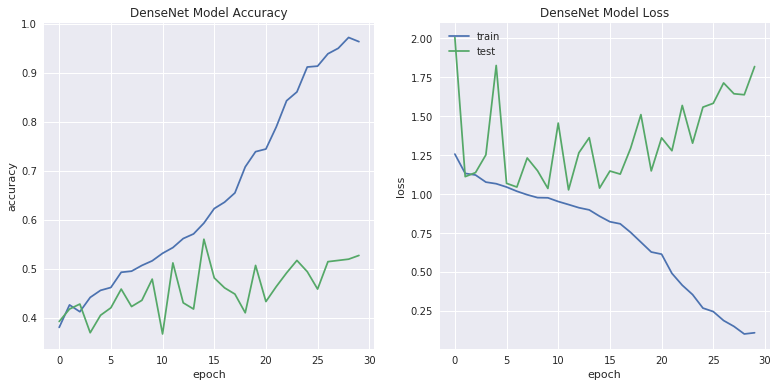

In [126]:
plot_model(dense_history, 'DenseNet')

The DenseNet performs significantly better than the previous models posting the best loss with the fewest number epochs. The number of epochs was limited to 30, due to time constraints but based on the general trend, it does not seem like the loss value would have improved for the better.

- Best Loss: 1.02712

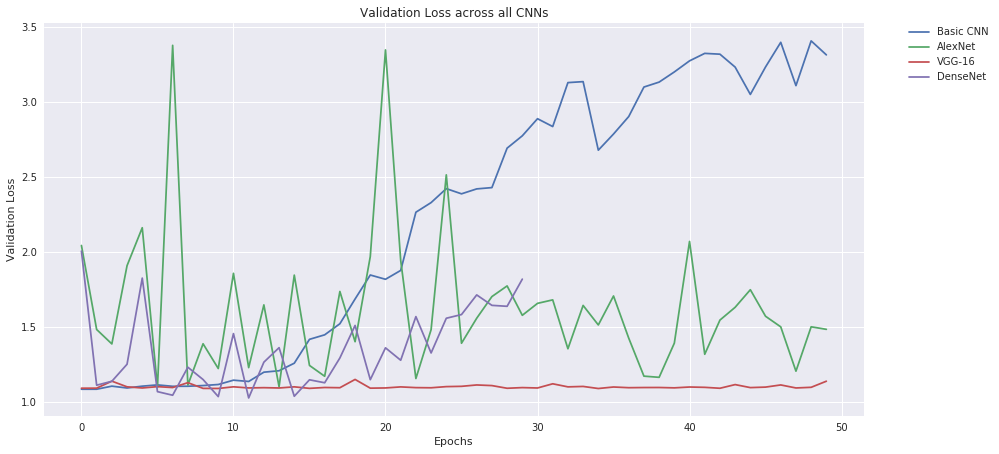

In [114]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(basic_cnn_history.history['val_loss'], label='Basic CNN')
plt.plot(alexnet_history.history['val_loss'], label='AlexNet')
plt.plot(vgg_history.history['val_loss'], label='VGG-16')
plt.plot(dense_history.history['val_loss'], label='DenseNet')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Validation Loss across all CNNs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.rcParams['figure.facecolor']= 'white'

The DenseNet model has the best performing models. The VGG-16 model has the least amount of variance and has consistently low loss values. The Basic CNN loss values explode as time passes. The AlexNet model has the most amount of variance and is the least predictable model.

The goal is to use these 'weak' learners in an ensemble to better predict the type likelihood.

## Predicting Singular Images

Firstly, I'm modifying each model's function and grabbing the checkpointed weights from the best performing models storeed in the hdf5 files. This is achieved using the load_weights() function.

In [40]:
def basic_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3),
                     data_format="channels_last"))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.load_weights("basiccnn.best.weight.hdf5")

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


def alexnet_model():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(3,3),
                     strides=(2,2),
                     activation='relu',
                     padding='same',
                     input_shape=(64,64,3),
                     data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=(2,2),
                           strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.load_weights("alexnet.best.weight.hdf5")

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


def vgg_model():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(64, 64, 3), data_format='channels_last'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D(padding=(1,1), data_format='channels_last'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=3, strides=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    
    model.load_weights("vgg.best.weight.hdf5")
    

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    return model



In [41]:
# Dense Block
def add_denseblock(input):
    temp = input
    for _ in range(10):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(20, (3,3), 
                            use_bias=False ,padding='same')(relu)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat

    return temp

def add_transition(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(20, (1,1), 
                               use_bias=False ,padding='same')(relu)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)

    return avg

def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(3, activation='softmax')(flat)

    return output
    
def dense_model():  

    input = Input(shape=(64, 64, 3,))
    First_Conv2D = Conv2D(20, (3,3), use_bias=False ,padding='same')(input)

    First_Block = add_denseblock(First_Conv2D)
    First_Transition = add_transition(First_Block)

    Second_Block = add_denseblock(First_Transition)
    Second_Transition = add_transition(Second_Block)

    Third_Block = add_denseblock(Second_Transition)
    Third_Transition = add_transition(Third_Block)

    Last_Block = add_denseblock(Third_Transition)
    output = output_layer(Last_Block)
    
    dense_model = Model(inputs=[input], outputs=[output])
    
    dense_model.load_weights("densenet-best-weight.hdf5")

    dense_model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return dense_model

In [42]:
# Saving each model with the checkpointed weights to new variables.
cnn_saved = basic_cnn_model()
alex_saved = alexnet_model()
vgg_saved = vgg_model()
dense_saved = dense_model()

In [43]:
def single_get_and_crop_image(input):
    '''
    Modifying the get_and_crop_image() function to take in only 1 image for processing.
    '''
    
    img = cv2.imread(input)
    initial_shape = img.shape
    [img, rectangle_cropCircle, tile_size] = cropCircle(img)
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = Ra_space(imgLab, 1.0, 150)
    a_channel = np.reshape(Ra[:,1], (w,h))
    
    g = mixture.GaussianMixture(n_components = 2, covariance_type = 'diag', random_state = 0, init_params = 'kmeans')
    image_array_sample = shuffle(Ra, random_state=0)[:1000]
    g.fit(image_array_sample)
    labels = g.predict(Ra)
    labels += 1 # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.
    
    # The cluster that has the highest a-mean is selected.
    labels_2D = np.reshape(labels, (w,h))
    gg_labels_regions = measure.regionprops(labels_2D, intensity_image = a_channel)
    gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
    cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

    mask = np.zeros((w * h,1),'uint8')
    mask[labels==cervix_cluster] = 255
    mask_2D = np.reshape(mask, (w,h))

    cc_labels = measure.label(mask_2D, background=0)
    regions = measure.regionprops(cc_labels)
    areas = [prop.area for prop in regions]

    regions_label = [prop.label for prop in regions]
    largestCC_label = regions_label[areas.index(max(areas))]
    mask_largestCC = np.zeros((w,h),'uint8')
    mask_largestCC[cc_labels==largestCC_label] = 255

    img_masked = img.copy()
    img_masked[mask_largestCC==0] = (0,0,0)
    img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY);
            
    _,thresh_mask = cv2.threshold(img_masked_gray,0,255,0)
            
    kernel = np.ones((11,11), np.uint8)
    thresh_mask = cv2.dilate(thresh_mask, kernel, iterations = 1)
    thresh_mask = cv2.erode(thresh_mask, kernel, iterations = 2)
    _, contours_mask, _ = cv2.findContours(thresh_mask.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours_mask, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(img, main_contour, -1, 255, 3)
    
    x,y,w,h = cv2.boundingRect(main_contour)
    
    rectangle = [x+rectangle_cropCircle[2],
                 y+rectangle_cropCircle[0],
                 w,
                 h,
                 initial_shape[0],
                 initial_shape[1],
                 tile_size[0],
                 tile_size[1]]

    return rectangle

In [44]:
def preprocess_image(image):
    '''
    Repurposing the crop and border additions from an earlier process.
    '''
    
    # return crop dimensions
    x, y, w, h, init_0, init_1, new_dim_0, new_dim_1 = single_get_and_crop_image(image)
    
    # read in image
    img = cv2.imread(image)
    
    # resize to new image dimensions
    resized = cv2.resize(img, (new_dim_0, new_dim_1))

    # crop image to segmented area
    crop_img = resized[y:y+h, x:x+w]
    
    # resize image to an even smaller value for faster processing
    desired_size = 64
    old_size = crop_img.shape[:2]
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    im = cv2.resize(crop_img, (new_size[1], new_size[0]))
    
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    
    new_im = new_im / 255
    
    return new_im

In [45]:
def reshape_img(image):
    sample = preprocess_image(image)
    reshaped_sampled = np.expand_dims(sample, axis=0)
    return reshaped_sampled

In [46]:
models = [cnn_saved, alex_saved, vgg_saved, dense_saved]
model_names = ['Basic CNN', 'AlexNet', 'VGG-16', 'DenseNet']

In [47]:
def return_predictions(image):
    print('Type Probabilities')
    for i, model in enumerate(models):
        
        # dict used to store type name and probability for each model
        # used to grab the max
        quick_dict = {}
        
        print(model_names[i])
        preds = model.predict(image)[0]
        for j, pred in enumerate(preds):
            c_type = j + 1
            quick_dict[pred] = c_type
            print('Type {}: {:.2f}'.format(c_type, pred))
            
        max_pred = max(quick_dict.keys())
        print('Prediction: Type {}'.format(quick_dict[max_pred]))
            
        print(' ')

## Testing on Sample Images 

In [48]:
sampled_image1 = '../Sample_Images/Type1/6684.jpg'
sample1 = reshape_img(sampled_image1)

return_predictions(sample1)

Type Probabilities
Basic CNN
Type 1: 0.40
Type 2: 0.39
Type 3: 0.22
Prediction: Type 1
 
AlexNet
Type 1: 0.29
Type 2: 0.33
Type 3: 0.38
Prediction: Type 3
 
VGG-16
Type 1: 0.29
Type 2: 0.37
Type 3: 0.33
Prediction: Type 2
 
DenseNet
Type 1: 0.49
Type 2: 0.44
Type 3: 0.08
Prediction: Type 1
 


sampled_image2 = '../Sample_Images/Type2/6893.jpg'
sample2 = reshape_img(sampled_image2)

return_predictions(sample2)

In [50]:
sampled_image3 = '../Sample_Images/Type3/6699.jpg'
sample3 = reshape_img(sampled_image3)

return_predictions(sample3)

Type Probabilities
Basic CNN
Type 1: 0.27
Type 2: 0.33
Type 3: 0.40
Prediction: Type 3
 
AlexNet
Type 1: 0.28
Type 2: 0.34
Type 3: 0.38
Prediction: Type 3
 
VGG-16
Type 1: 0.29
Type 2: 0.37
Type 3: 0.33
Prediction: Type 2
 
DenseNet
Type 1: 0.23
Type 2: 0.27
Type 3: 0.50
Prediction: Type 3
 


In [ ]:
On the three randomly sampled images the models have managed to pick the correct 